In [ ]:
from IPython.display import Audio

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the NSynth dataset
dataset, info = tfds.load('nsynth', split='train', with_info=True)




Dl Completed...:   0%|          | 0/1069 [00:00<?, ? file/s]

Dataset nsynth downloaded and prepared to /root/tensorflow_datasets/nsynth/full/2.3.3. Subsequent calls will reuse this data.


KeyError: ignored

{'audio': <tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 3.9068875e-01,  7.7416581e-01,  2.0962563e-01, ...,
       -3.8983394e-08,  5.8440929e-08, -7.0936366e-08], dtype=float32)>, 'id': <tf.Tensor: shape=(), dtype=string, numpy=b'vocal_synthetic_010-102-100'>, 'instrument': {'family': <tf.Tensor: shape=(), dtype=int64, numpy=10>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1000>, 'source': <tf.Tensor: shape=(), dtype=int64, numpy=2>}, 'pitch': <tf.Tensor: shape=(), dtype=int64, numpy=102>, 'qualities': {'bright': <tf.Tensor: shape=(), dtype=bool, numpy=True>, 'dark': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'distortion': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'fast_decay': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'long_release': <tf.Tensor: shape=(), dtype=bool, numpy=True>, 'multiphonic': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'nonlinear_env': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'percussive': <tf.Tensor: shape=(), dtype=bo

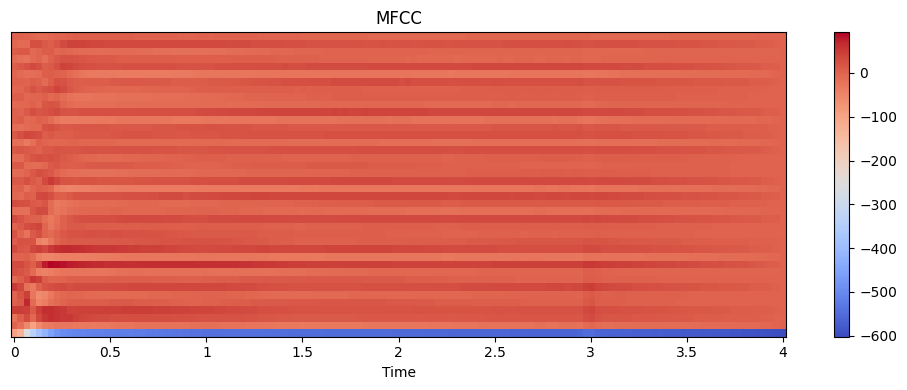

tf.Tensor(10, shape=(), dtype=int64)


In [ ]:
# Iterate over the dataset
import librosa
import librosa.display
import matplotlib.pyplot as plt

filtered_dataset = dataset.filter(lambda x: x['instrument']['family'] == 10)

for example in filtered_dataset.take(1):  # Only take a single example
    audio = example['audio'].numpy()
    print(example)
    # rate = example['sample_rate']
    label = example['instrument']['family']


sample_rate = 16000
# stft = librosa.stft(audio)
# # Convert the STFT to a spectrogram
# spectrogram = librosa.amplitude_to_db(abs(stft))

# print(spectrogram.shape)
# # Plot the spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='hz')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Spectrogram')
# plt.show()

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

# Plot the MFCCs
print(mfccs.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

print(label)
Audio(audio, rate=sample_rate)

In [ ]:
import librosa
import numpy as np
from sklearn.decomposition import NMF
import tensorflow as tf

# Let's assume 'audio' is your loaded audio signal and 'sample_rate' is the sampling rate
filtered_dataset = dataset.filter(lambda x: x['instrument']['family'] == 1)
x_train = dict()
y_train = dict()

for i in range(10):
  filtered_dataset = dataset.filter(lambda x: x['instrument']['family'] == i)
  x_train = {**x_train, **{f"{i}":[]}}
  y_train = {**y_train, **{f"{i}":[]}}
  for sample in filtered_dataset:
    audio = sample['audio'].numpy()
    noise = np.random.normal(0,0.01, audio.shape)
    noisy_audio = noise + audio
    stft = librosa.stft(noisy_audio)
    magnitude, phase = librosa.magphase(stft)
    x_train[i].append(np.flatten(magnitude))
    stft = librosa.stft(audio)
    magnitude, phase = librosa.magphase(stft)
    y_train[i].append(np.flatten(magnitude))

sample_rate = 16000
input_shape = x_train['0'][0].shape
input_shape_flatten = input_shape[0] * input_shape[1]
n_components = 2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_shape=input_shape_flatten, n_components*input_shape[1]),
    tf.keras.layers.Activation(tf.keras.activations.softplus),
    tf.keras.layers.Dense(input_shape_flatten),
    tf.keras.layers.Activation(tf.keras.activations.softplus)
])

def loss_function(y_true, y_pred):
    input_len = y_true.shape[0]
    loss = 0
    for i in range(input_len):
      loss += y_true[i]*(np.log(y_true[i]) - np.log(y_pred[i])) - y_true[i] + y_pred[i]

    return loss


# Apply NMF to the magnitude of the STFT (since phase information is not non-negative)

model = NMF(n_components=n_components, init='random', random_state=0)
W = model.fit_transform(magnitude)
H = model.components_


# # Reconstruct the magnitude from NMF components
# idx = 0
# reconstructed_magnitude = np.dot(W[:,idx], H[idx])

# # Combine with original phase
# reconstructed_stft = reconstructed_magnitude * phase

# Inverse STFT to get the audio signal
# reconstructed_audio = librosa.istft(reconstructed_stft)
reconstructed_sources = []
for i in range(n_components):
    # Reconstruct the magnitude for each source
    source_magnitude = np.outer(W[:, i], H[i])

    # Combine with original phase information
    source_stft = source_magnitude * phase

    # Inverse STFT to get the time-domain signal of each source
    source_audio = librosa.istft(source_stft)
    reconstructed_sources.append(source_audio)

# reconstructed_audio is the approximation of the original audio after NMF decomposition and reconstruction


{'audio': <tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 1.5671911e-05, -1.4248734e-05,  2.1496215e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>, 'id': <tf.Tensor: shape=(), dtype=string, numpy=b'brass_acoustic_040-067-127'>, 'instrument': {'family': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=234>, 'source': <tf.Tensor: shape=(), dtype=int64, numpy=0>}, 'pitch': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'qualities': {'bright': <tf.Tensor: shape=(), dtype=bool, numpy=True>, 'dark': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'distortion': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'fast_decay': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'long_release': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'multiphonic': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'nonlinear_env': <tf.Tensor: shape=(), dtype=bool, numpy=False>, 'percussive': <tf.Tensor: shape=(), dtype=bool,

In [ ]:
print(H.shape)

(2, 126)


In [ ]:
Audio(reconstructed_sources[0], rate=sample_rate)

In [ ]:
Audio(audio, rate=sample_rate)

In [ ]:
Audio(noisy_audio, rate=sample_rate)

In [ ]:
import tensorflow as tf
